# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,recall_score, precision_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the cleaned data
df = pd.read_csv('Cleaned_Loan_Status.csv') 

In [3]:
#Print the first few rows of the dataframe
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [4]:
#Print the column names
print(df.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [5]:
#Printing the data types of each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB
None


In [6]:
#Splitting the data in datatype
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

In [7]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [8]:
#Checking the shape of the dataset
print(f"Shape Of the data: {df.shape}")

Shape Of the data: (614, 12)


In [9]:
#Checking the target variable distribution
print(df['Loan_Status'].value_counts())

Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [10]:
#Finding total income as  it is a reason for acceptance of loan
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['EMI'] = df['LoanAmount'] / (df['Loan_Amount_Term']) #Equated Monthly Installment
df['loan_by_income'] = df['LoanAmount'] / df['Total_Income']

In [11]:
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Total_Income         0
EMI                  0
loan_by_income       0
dtype: int64

In [12]:
categorical_cols 

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')

In [13]:
#Use Label Encoding for binary categorical variables
le = LabelEncoder()
categorical_cols = 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed','Property_Area'
for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

In [14]:
#Encoding the target variable
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

In [15]:
#Removing the skewwedness in the data
from scipy.stats import boxcox, yeojohnson

for col in numerical_cols:
    if df[col].isnull().any():  # skip nulls for simplicity
        continue

    skew_val = df[col].skew()

    if skew_val > 0.5:
        # Right-skewed → use log or sqrt or Box-Cox
        if (df[col] > 0).all():
            df[col], _ = boxcox(df[col] + 1e-6)  # +1e-6 avoids zero
        else:
            df[col], _ = yeojohnson(df[col])  # handles zeros/negatives
    elif skew_val < -0.5:
        # Left-skewed → square or cube transform
        df[col] = np.power(df[col], 2)


In [16]:
# Removing outliers only in numeric columns
numerical_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = ~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)
df = df[mask]
print(f"Shape Of the data after removing outliers: {df.shape}")


Shape Of the data after removing outliers: (566, 15)


In [17]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,EMI,loan_by_income
0,1,0,0,0,0,5.784390,0.000000,6.034999,129600.0,1.0,2,1,5849.0,0.406700,0.025032
1,1,1,1,0,0,5.681300,9.149314,5.841340,129600.0,1.0,0,0,6091.0,0.355556,0.021015
2,1,1,0,0,1,5.496074,0.000000,4.914614,129600.0,1.0,2,1,3000.0,0.183333,0.022000
3,1,1,0,1,0,5.428743,9.845889,5.749027,129600.0,1.0,2,1,4941.0,0.333333,0.024287
4,1,0,0,0,0,5.795017,0.000000,5.980529,129600.0,1.0,2,1,6000.0,0.391667,0.023500


In [18]:
#Separating features and target variable
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [19]:
X.shape, y.shape

((566, 14), (566,))

In [20]:
#Performing Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((424, 14), (142, 14), (424,), (142,))

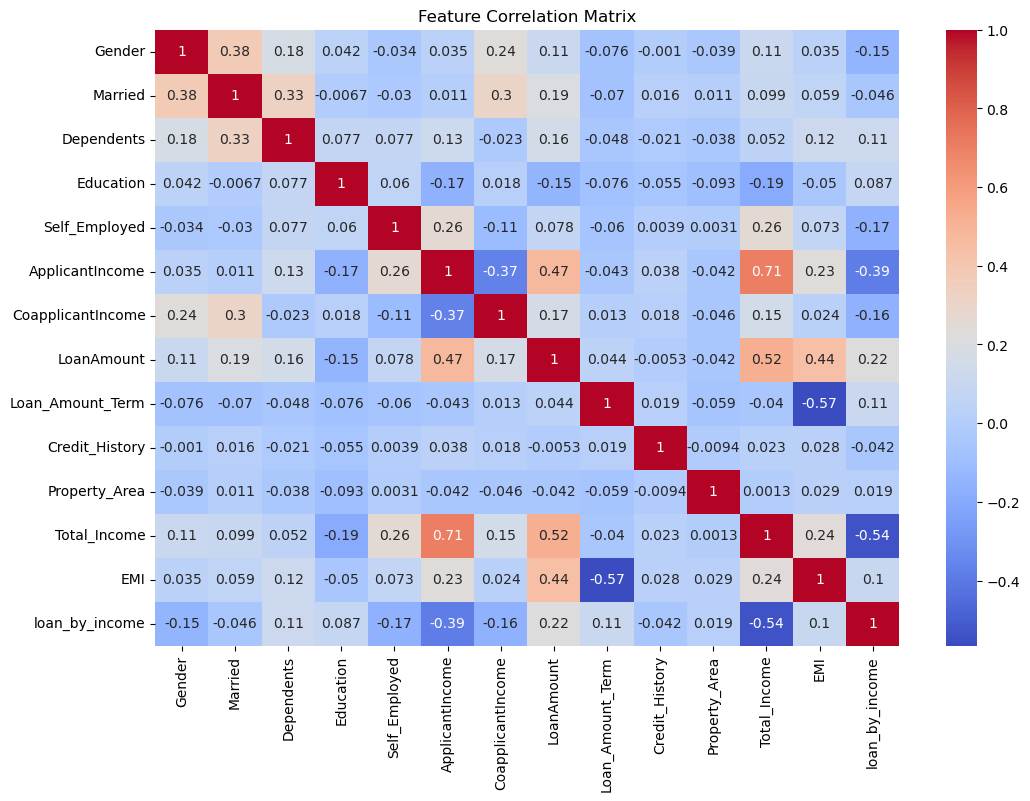

In [22]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
plt.figure(figsize=(12,8))
sns.heatmap(X_train_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Here,the numeric columns are not correalted if the  columns are correlated use this 

In [23]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [24]:
cor_features = correlation(X_train_numeric, 0.8)
print(f"Correlated Geatures are {len(set(cor_features))}")

Correlated Geatures are 0


In [25]:
X_train_category = X_train.select_dtypes(include=['object']).columns

# Feature Scaling and Normalization

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((424, 14), (142, 14), (424,), (142,))

In [27]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,EMI,loan_by_income
114,1,0,0,0,0,5.722614,0.00000,5.725059,129600.0,1.0,1,5050.0,0.327778,0.023366
247,1,1,1,1,0,5.835015,0.00000,5.939013,32400.0,1.0,2,6608.0,0.761111,0.020732
613,0,0,0,0,1,5.681300,0.00000,5.896359,129600.0,0.0,1,4583.0,0.369444,0.029020
461,1,1,3,0,0,5.899704,0.00000,5.841340,32400.0,1.0,2,7740.0,0.711111,0.016537
441,1,1,0,0,0,5.908051,9.45116,6.336396,129600.0,1.0,0,9734.0,0.500000,0.018492


In [28]:
#Training and Testing on multiple models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [29]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"Precision Score: {precision_score(y_test, y_pred, average='weighted')}")
    print("-" * 50)

Model: Logistic Regression
[[ 18  21]
 [  3 100]]
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        39
           1       0.83      0.97      0.89       103

    accuracy                           0.83       142
   macro avg       0.84      0.72      0.75       142
weighted avg       0.83      0.83      0.81       142

Accuracy: 0.8309859154929577
F1 Score: 0.8124245472837023
Recall Score: 0.8309859154929577
Precision Score: 0.8348770307797196
--------------------------------------------------
Model: Decision Tree
[[20 19]
 [31 72]]
              precision    recall  f1-score   support

           0       0.39      0.51      0.44        39
           1       0.79      0.70      0.74       103

    accuracy                           0.65       142
   macro avg       0.59      0.61      0.59       142
weighted avg       0.68      0.65      0.66       142

Accuracy: 0.647887323943662
F1 Score: 0.6604714195827888
Recall Score: 0.64788

Here Random Forest Performed,Decision Tree Better and we will improve it by hyperparameter tuning

In [30]:
model_rf = RandomForestClassifier(random_state=42,class_weight='balanced')
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print("Random Forest Classifier")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

Random Forest Classifier
[[19 20]
 [ 8 95]]
              precision    recall  f1-score   support

           0       0.70      0.49      0.58        39
           1       0.83      0.92      0.87       103

    accuracy                           0.80       142
   macro avg       0.76      0.70      0.72       142
weighted avg       0.79      0.80      0.79       142

Accuracy: 0.8028169014084507
F1 Score: 0.7903182229322557


In [31]:
#Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid,
                            cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Tuned Random Forest Classifier")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuned Random Forest Classifier
[[20 19]
 [10 93]]
              precision    recall  f1-score   support

           0       0.67      0.51      0.58        39
           1       0.83      0.90      0.87       103

    accuracy                           0.80       142
   macro avg       0.75      0.71      0.72       142
weighted avg       0.79      0.80      0.79       142

Accuracy: 0.795774647887324
F1 Score: 0.7867300872983096
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [32]:
# Using Bagging Classifier
from sklearn.ensemble import BaggingClassifier
bagging_model = BaggingClassifier(
    n_estimators=50,
    max_samples=0.7,
    max_features=0.7,
    random_state=42
)
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
print("Bagging Classifier")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

Bagging Classifier
[[22 17]
 [11 92]]
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        39
           1       0.84      0.89      0.87       103

    accuracy                           0.80       142
   macro avg       0.76      0.73      0.74       142
weighted avg       0.80      0.80      0.80       142

Accuracy: 0.8028169014084507
F1 Score: 0.7973912658339977


In [33]:
# Base model
dt = DecisionTreeClassifier(random_state=42)

# Parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)
#Final Evaluation
model_df = grid_search.best_estimator_
y_pred = model_df.predict(X_test)
print("Final Evaluation of the Decision Tree Classifier with Best Parameters")
print(confusion_matrix(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best CV Accuracy: 0.8303986710963456
Final Evaluation of the Decision Tree Classifier with Best Parameters
[[19 20]
 [ 4 99]]
F1 Score: 0.8152682441642006
Accuracy: 0.8309859154929577


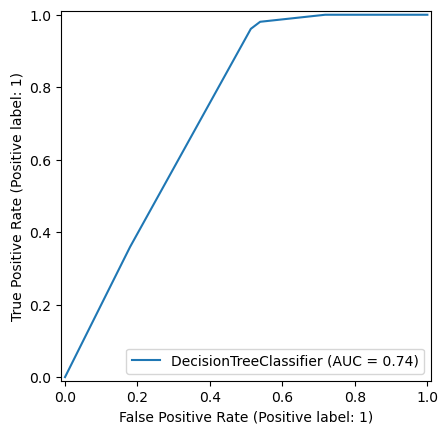

In [34]:
#Plot the roc curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model_df, X_test, y_test)
plt.show()

In [36]:
#Saving the best model to a pickle file
with open('model_df.pkl', 'wb') as f:
    pickle.dump(model_df, f)

In [40]:
import numpy as np

# Base 11 features
# Format (example): [Gender, Married, Dependents, Education, Self_Employed,
# ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,
# Credit_History, Property_Area_encoded]
features_values = [1, 0, 0, 1, 0, 5849, 0.0, 146.41216216216216, 360.0, 1.0, 0]

# --- Engineered features ---
# total_income = applicant_income + coapplicant_income
total_income = features_values[5] + features_values[6]

# emi = loan_amount / loan_amount_term
emi = features_values[7] / features_values[8] if features_values[8] != 0 else 0

# loan_by_income = loan_amount / total_income
loan_by_income = features_values[7] / total_income if total_income != 0 else 0

# Append engineered features
features_values.extend([total_income, emi, loan_by_income])

# Convert to numpy and reshape for prediction
input_data = np.array(features_values).reshape(1, -1)

# 🔹 Apply scaler if your model was trained on scaled data
# input_data = scaler.transform(input_data)

# 🔹 Make prediction
pred = model_df.predict(input_data)

# 🔹 Interpret output
print("Prediction:", pred[0])
print("Loan Status:", "Accepted ✅" if pred[0] == 1 else "Rejected ❌")


Prediction: 1
Loan Status: Accepted ✅
